In [1]:
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
from pathlib import Path
import glob
import regex
import dill
import gzip
import toolz, itertools, more_itertools
from collections import Counter, OrderedDict

In [6]:
import optuna
import sklearn

In [7]:
import math
import pandas as pd 
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTETomek
import statistics
import shap
### SEED ###
np.random.seed(42)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

## DATA directory

In [8]:
DIR = Path(r'C:\Users\Abhij\OneDrive\Documents\GitHub\DNA-structure-prediction')
assert DIR.exists()
DATA = DIR/"data"

## Helper Functions to read pickled data

In [9]:
def make_dirs(*, name: str) -> ():
    try:
        _file = DIR / "data"
        os.mkdir(_file / name)
    except FileExistsError:
        print("Dir exists")


def pkl_it(dataframe, filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "wb") as fh:
        dill.dump(dataframe, fh)
    return


def unpkl_it(filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "rb") as fh:
        return dill.load(fh)

make_dirs(name="results")
make_dirs(name="pkl")

Dir exists
Dir exists


## A flexible helper Class for running different ML algorithms  
It automatically chooses the best threshold for classification by locating the arg_max (index) of the best F-score  

In [10]:
import logging
from collections import defaultdict
logging.basicConfig(filename=DATA/'results.log', level=logging.INFO)


class Call_Plot():
    
    def __init__(self, sklearn_model=True, model_name="SVM", repeated_k_fold=False):
        plt.close()
        self.model_name = model_name
        self.fig, self.ax = plt.subplots()
        self.ax.plot([0,1], [0,1], linestyle='--', label='Random choice')
        self.ax.set_xlabel('False Positive Rate', fontsize=12)
        self.ax.set_ylabel('True Positive Rate', fontsize=12)
        
        self.fig2, self.ax2 = plt.subplots()
        self.ax2.set_xlabel('Recall', fontsize=12)
        self.ax2.set_ylabel('Precision', fontsize=12)

        self.tprs = []
        self.aucs = []
        self.mean_fpr = np.linspace(0, 1, 100)
        self.no_skill = []
        self.sklearn_model = sklearn_model
        self.results = defaultdict(list)
        self.repeated_k_fold = repeated_k_fold
        
        
    def Plot(self, data: dict, model, idx):
        if self.sklearn_model:
            y_pred_val = model.predict_proba(data["X_val"])[:,1]
        else:
            y_pred_val = model.predict(data["X_val"])
        
        #Precision-Recall
        precision, recall, thresholds = precision_recall_curve(data["y_val"], y_pred_val)
        no_skill = len(data["y_val"][data["y_val"]==1]) / len(data["y_val"])
        self.no_skill.append(no_skill)
        avg_pr = average_precision_score(data["y_val"], y_pred_val)
        auc_pr = sklearn.metrics.auc(recall, precision)
        if self.repeated_k_fold:
            self.ax2.plot(recall, precision, marker='.', label=f'Run {(idx)//5+1} Test Fold{(idx)%5+1}: AUC PR={auc_pr:.2f}')
        else:
            self.ax2.plot(recall, precision, marker='.', label=f'Test Fold{(idx)+1}: AUC PR={auc_pr:.2f}')
        
        # convert to f score
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix_pr = np.argmax(fscore)
        self.ax2.scatter(recall[ix_pr], precision[ix_pr], marker='o', color='black')
        
        Accuracy = sklearn.metrics.accuracy_score(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        target_names = ['B-DNA', 'A-DNA']
        print(classification_report(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0), target_names=target_names))
        F1 = sklearn.metrics.f1_score(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        MCC = sklearn.metrics.matthews_corrcoef(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        cohen_kappa_score = sklearn.metrics.cohen_kappa_score(data["y_val"], np.where(y_pred_val > thresholds[ix_pr], 1, 0))
        logging.info(f'Fold {idx + 1}: Average PR: {avg_pr:.2f} ')
        logging.info(f'Fold {idx + 1}: AUC PR: {auc_pr:.2f} ')
        logging.info(f'Fold {idx + 1}: Best Threshold_f-score={thresholds[ix_pr]:.2f}, F-Score={fscore[ix_pr]}')
        logging.info(f'Fold {idx + 1}: Accuracy: {Accuracy:.2f}')
        logging.info(f'Fold {idx + 1}: F1: {F1:.2f}')
        logging.info(f'Fold {idx + 1}: MCC: {MCC:.2f}')
        
        #ROC-AUC
        fpr, tpr, thresholds_auc = roc_curve(data["y_val"], y_pred_val)
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        if self.repeated_k_fold:
            self.ax.plot(fpr, tpr, marker='.',
                     label=f'Run {(idx)//5+1} Test Fold{(idx)%5+1}: AUC={sklearn.metrics.auc(fpr, tpr):.2f}')
        else:
            self.ax.plot(fpr, tpr, marker='.',
                     label=f'Test Fold{(idx)+1}: AUC={sklearn.metrics.auc(fpr, tpr):.2f}')
        self.ax.scatter(fpr[ix], tpr[ix], marker='o', color='black')
        # axis labels
        self.ax.legend(loc="lower left")
        # Mean plot
        interp_tpr = np.interp(self.mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        self.tprs.append(interp_tpr)
        self.aucs.append(gmeans[ix])
        
        logging.info(f'Fold {idx + 1}: ROC-AUC: {sklearn.metrics.auc(fpr, tpr):.2f}')
        logging.info(f'Fold {idx + 1}: Best Threshold_ROC={thresholds_auc[ix]:.2f}, G-Mean_ROC={gmeans[ix]:.2f}')
        print("Average PR: ", avg_pr )
        print("AUC PR: ", auc_pr)
        print('Best Threshold_f-score=%f, F-Score=%.3f' % (thresholds[ix_pr], fscore[ix_pr]))
        print("AUC: ", sklearn.metrics.auc(fpr, tpr))
        print('Best Threshold_ROC=%f, G-Mean_ROC=%.3f' % (thresholds_auc[ix], gmeans[ix]))
        print("Accuracy: ", Accuracy )
        print("F1: ", F1 )
        print("MCC: ", MCC )
        self.results["Average PR"].append(avg_pr)
        self.results["AUC PR"].append(auc_pr)
        self.results["ROC AUC"].append(sklearn.metrics.auc(fpr, tpr))
        self.results["Accuracy"].append(Accuracy)
        self.results["F1"].append(F1)
        self.results["MCC"].append(MCC)
        self.results["cohen_kappa_score"].append(cohen_kappa_score)

    
    def post_Plot(self):
        from sklearn.metrics import auc
        mean_tpr = np.mean(self.tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(self.mean_fpr, mean_tpr)
        std_auc = np.std(self.aucs)
        self.ax.plot(self.mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

        std_tpr = np.std(self.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        self.ax.fill_between(self.mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
        self.ax.legend(loc=(0.45, .05),fontsize='medium')
        self.fig.savefig(DIR/"data"/"results"/f"{self.model_name}_AUC_ROC.png", dpi=600)
        no_skill = np.mean(np.array(self.no_skill))
        self.ax2.plot([0,1], [no_skill,no_skill], linestyle='--', label="Random")
        self.ax2.legend(loc=(0.050, .08),fontsize='medium')
        self.fig2.savefig(DIR/"data"/"results"/f"{self.model_name}_AUC_PR.png", dpi=600)
        

## Read curated dataset

In [11]:
curated_data = unpkl_it("curated_dataset")
curated_data

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


In [12]:
#Check if any sequence has duplicate features
curated_data.drop_duplicates(subset=['AA/TT', 'GG/CC', 'AC/GT',
                                          'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC'], keep='last')

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


## Nested Cross-validation

In [13]:
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import RepeatedStratifiedKFold

The function gen_data is a flexible generator that implements outer fold of Nested CV  
Here, we are using 5-fold stratified Nested cross validation (n_splits = 5)  

In [15]:

def gen_data(data: pd.DataFrame, RESAMPLING: bool=False):
    X, y = data.drop(labels="target", axis=1), data["target"]
    sss = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    for train_index, val_index in sss.split(X, y):
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X.iloc[train_index,:], y.iloc[train_index])
        yield {"X_train": X_resampled if RESAMPLING else X.iloc[train_index,:],
               "y_train": y_resampled if RESAMPLING else y.iloc[train_index],
              "X_val": X.iloc[val_index,:], "y_val": y.iloc[val_index]}

This generator implements inner fold of Nested CV, where we tune hyperparameters.

In [16]:
def gen_data_for_tuningHP(data: dict, RESAMPLING: bool=True):
    
    X, y = data["X_train"], data["y_train"]
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
    for train_index, val_index in sss.split(X, y):
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X.iloc[train_index,:], y.iloc[train_index])
        yield {"X_train": X_resampled if RESAMPLING else X.iloc[train_index,:],
               "y_train": y_resampled if RESAMPLING else y.iloc[train_index],
               "X_val": X.iloc[val_index,:], "y_val": y.iloc[val_index]}
    

## Helper function: train_test_folds_reader

This generator function reads the data from the "train_test_folds" folder and gives the same Train-Test splits
used by us. At each iteration it yields a single split of the data
Alternatively, you can run the `gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING=False)`, which gives the same split provided that you use the same seed.


In [17]:

def train_test_folds_reader(*, folder) -> dict:
    TRAIN_TEST = Path(folder)
    for i in range(5):
        yield {"X_train": pd.read_excel(folder/f"train_fold_{i+1}.xls", index_col=0).drop(labels=["target", "sequence", "item"], axis=1),
               "y_train": pd.read_excel(folder/f"train_fold_{i+1}.xls", index_col=0)["target"],
               "X_val":   pd.read_excel(folder/f"test_fold_{i+1}.xls", index_col=0).drop(labels=["target", "sequence", "item"], axis=1),
               "y_val":   pd.read_excel(folder/f"test_fold_{i+1}.xls", index_col=0)["target"],}

## Read the best SVM hyperparameters

In [18]:
best_svm_params = pd.read_csv(DATA/"tuned_hyperparameters"/"best_svm_params.csv", index_col=0)

In [19]:
best_svm_params

,C,break_ties,cache_size,class_weight,coef0,decision_function_shape,degree,gamma,kernel,max_iter,probability,random_state,shrinking,tol,verbose
Model_1,0.5,False,200,balanced,0,ovr,3,scale,rbf,-1,True,42,True,0.001,False
Model_2,0.4,False,200,balanced,0,ovr,3,scale,linear,-1,True,42,True,0.001,False
Model_3,0.5,False,200,balanced,0,ovr,3,scale,rbf,-1,True,42,True,0.001,False
Model_4,0.6,False,200,balanced,0,ovr,3,scale,rbf,-1,True,42,True,0.001,False
Model_5,0.3,False,200,balanced,0,ovr,3,scale,rbf,-1,True,42,True,0.001,False


## Set up SVM training

In [20]:
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
import optuna
from optuna.pruners import HyperbandPruner
import copy
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [21]:
def trainer(data, param_updater):
    train_x, train_y = data["X_train"], data["y_train"]
    
    param = {
        "probability": True,
        "class_weight": "balanced",
        "random_state": 42,
        "verbose": False,
    }
    param.update(param_updater)
    model = SVC(**param)
    model = make_pipeline(StandardScaler(), model)
    model.fit(train_x, train_y)
    return model


## Train, Run and evaluate performance of SVM using tuned hyperparameters
Here, we use the `train_test_folds_reader(folder=DATA/"train_test_folds")` to yield the same split of data as used us. We then use the tuned hyperparameters (best_svm_params) and convert it into a dictionary. We then train each model and evaluate the performance of each model on each test fold. Note that, alternatively we can also use the `gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING=False)` will give the same split of data if you use the same seed (42).

<IPython.core.display.Javascript object>


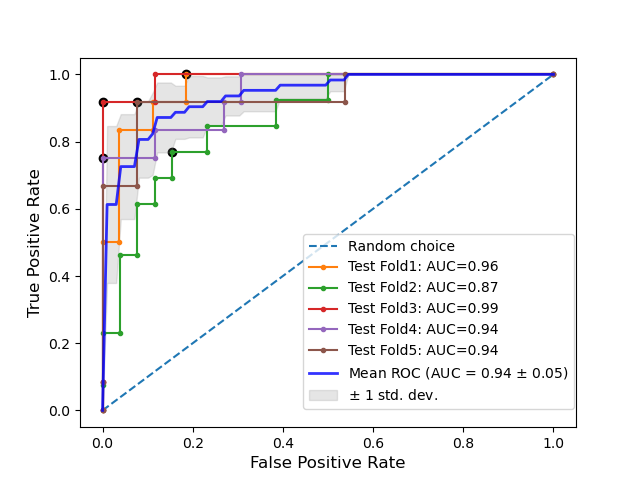

<IPython.core.display.Javascript object>


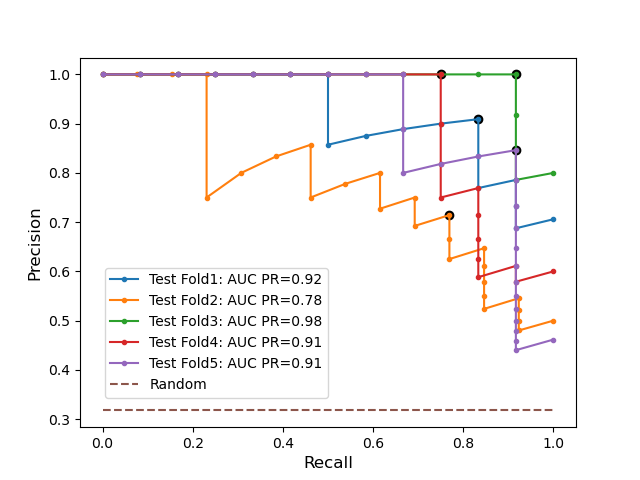

              precision    recall  f1-score   support

       B-DNA       0.90      0.96      0.93        27
       A-DNA       0.90      0.75      0.82        12

    accuracy                           0.90        39
   macro avg       0.90      0.86      0.87        39
weighted avg       0.90      0.90      0.89        39

Average PR:  0.9220480363862716
AUC PR:  0.9184307896624073
Best Threshold_f-score=0.417437, F-Score=0.870
AUC:  0.962962962962963
Best Threshold_ROC=0.241470, G-Mean_ROC=0.903
Accuracy:  0.8974358974358975
F1:  0.8181818181818182
MCC:  0.7535992817105361
              precision    recall  f1-score   support

       B-DNA       0.85      0.85      0.85        26
       A-DNA       0.69      0.69      0.69        13

    accuracy                           0.79        39
   macro avg       0.77      0.77      0.77        39
weighted avg       0.79      0.79      0.79        39

Average PR:  0.7865425424248953
AUC PR:  0.7763290040778728
Best Threshold_f-score=0.42279

In [22]:
plt.close()
# *************OUTER*************
plot_Model_SVM_test = Call_Plot(repeated_k_fold=False)
for outer_idx, elem in enumerate(train_test_folds_reader(folder=DATA/"train_test_folds")):
    # ***********Feed in the best hyperparams for each model************
    model = trainer(elem, best_svm_params.T.to_dict()
                    [f"Model_{outer_idx + 1}"])
    plot_Model_SVM_test.Plot(elem, model, outer_idx)
plot_Model_SVM_test.post_Plot()

In [23]:
pd.DataFrame(plot_Model_SVM_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.922048,0.918431,0.962963,0.897436,0.818182,0.753599,0.747573
1,0.786543,0.776329,0.872781,0.794872,0.692308,0.538462,0.538462
2,0.983333,0.982738,0.990385,0.947368,0.909091,0.879664,0.872483
3,0.915028,0.912397,0.942308,0.894737,0.800000,0.760117,0.732394
4,0.913267,0.910447,0.935897,0.894737,0.833333,0.756410,0.756410


In [24]:
pd.DataFrame(plot_Model_SVM_test.results).mean()

Average PR           0.904044
AUC PR               0.900068
ROC AUC              0.940867
Accuracy             0.885830
F1                   0.810583
MCC                  0.737650
cohen_kappa_score    0.729464
dtype: float64

## Running from scratch - Run and evaluate performance of SVM under 5-fold stratified Nested CV

In [25]:
import optuna

import copy


def objective(data, trial):
    train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]


    param = {
        "C": trial.suggest_discrete_uniform("C",0.1,1.0,0.1),
        "kernel": trial.suggest_categorical("kernel",["rbf",]),
        "gamma": trial.suggest_loguniform("gamma", 1e-3, 1e+3),
        "probability": True,
        "class_weight": "balanced",
        "random_state": 42,
        "verbose": False,
        
    }
    
    model = SVC(**param)
    model = make_pipeline(StandardScaler(), model)
    model.fit(train_x, train_y)
    return sklearn.metrics.roc_auc_score(valid_y, model.predict(valid_x))



In [26]:
import collections
Trial = collections.namedtuple("Trial",["value", "parameters"])

<IPython.core.display.Javascript object>


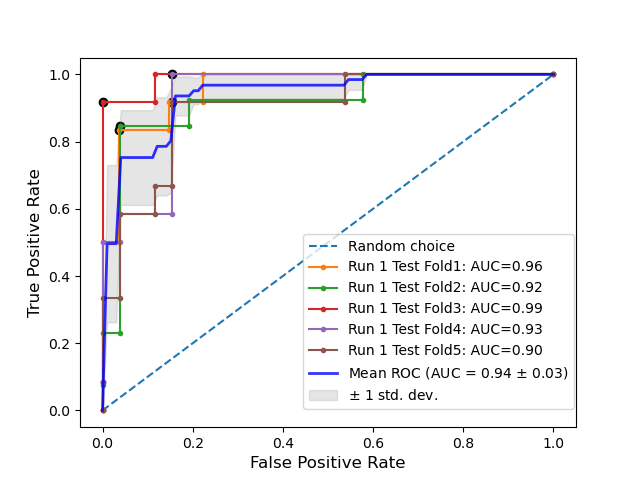

<IPython.core.display.Javascript object>


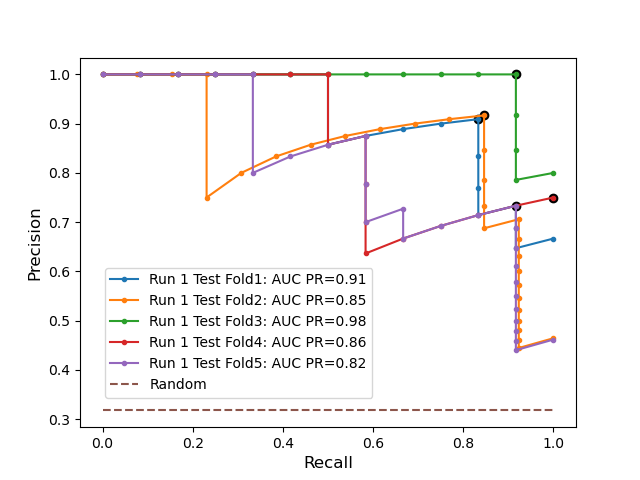

              precision    recall  f1-score   support

       B-DNA       0.90      0.96      0.93        27
       A-DNA       0.90      0.75      0.82        12

    accuracy                           0.90        39
   macro avg       0.90      0.86      0.87        39
weighted avg       0.90      0.90      0.89        39

Average PR:  0.9144149831649833
AUC PR:  0.9106398367427779
Best Threshold_f-score=0.587477, F-Score=0.870
AUC:  0.9567901234567902
Best Threshold_ROC=0.587477, G-Mean_ROC=0.896
Accuracy:  0.8974358974358975
F1:  0.8181818181818182
MCC:  0.7535992817105361
              precision    recall  f1-score   support

       B-DNA       0.89      0.96      0.93        26
       A-DNA       0.91      0.77      0.83        13

    accuracy                           0.90        39
   macro avg       0.90      0.87      0.88        39
weighted avg       0.90      0.90      0.90        39

Average PR:  0.857714670949965
AUC PR:  0.8498342752019221
Best Threshold_f-score=0.71804

In [27]:
plt.close()
optuna.logging.set_verbosity(optuna.logging.WARNING)
results = []
outer_models = {}
best_models_svm = {}
hack_svm = {}
# *************OUTER*************
plot_Model_svm = Call_Plot(sklearn_model=True, model_name="SVM", repeated_k_fold=True)
for outer_idx, elem in enumerate(gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING = False)):
    hack_svm[outer_idx] = elem
    study_dict = {}
    # ***********INNER************
    for idx, data_in in enumerate(gen_data_for_tuningHP(elem, RESAMPLING=True)):
        
        study = optuna.create_study(pruner=HyperbandPruner(max_resource="auto"),
                            direction="maximize")
        study.optimize((toolz.curry(objective)(data_in)), n_trials=100)

        #print("Number of finished trials: {}".format(len(study.trials)))

        trial = study.best_trial
        study_dict[idx] = Trial(trial.value, trial.params)
    arg_max = max(study_dict, key=lambda d: study_dict[d].value) #max for AUC
    best_models_svm[outer_idx] = trainer(elem, study_dict[arg_max].parameters)
    
    plot_Model_svm.Plot(elem, best_models_svm[outer_idx], outer_idx)
plot_Model_svm.post_Plot()


In [28]:
pd.DataFrame(plot_Model_SVM_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.922048,0.918431,0.962963,0.897436,0.818182,0.753599,0.747573
1,0.786543,0.776329,0.872781,0.794872,0.692308,0.538462,0.538462
2,0.983333,0.982738,0.990385,0.947368,0.909091,0.879664,0.872483
3,0.915028,0.912397,0.942308,0.894737,0.800000,0.760117,0.732394
4,0.913267,0.910447,0.935897,0.894737,0.833333,0.756410,0.756410


In [29]:
pd.DataFrame(plot_Model_SVM_test.results).mean()

Average PR           0.904044
AUC PR               0.900068
ROC AUC              0.940867
Accuracy             0.885830
F1                   0.810583
MCC                  0.737650
cohen_kappa_score    0.729464
dtype: float64